In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns


In [2]:
LOW_QUANTILE = 0.25
HIGH_QUANTILE = 0.2501

# Create a Folder to Store the Results
import os

if not os.path.exists("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE)):
    os.mkdir("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE))
    
save_path = "Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE) + "/"

## Data

### mRNA Expression Data

In [3]:
mRNA_df = pd.read_csv('Depmap Melanoma mRNA.csv')
mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
full_mRNA_df = pd.read_csv('Depmap Pancancer mRNA.csv')
full_mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Gene Dependency Data

In [5]:
# SWAP THIS TO RUN WITH GENE EFFECT
dependency_df = pd.read_csv('Depmap Melanoma Gene Effect.csv')
dependency_df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(dependency_df.shape)

(60, 17454)


### Cell Lines Data

In [6]:
cell_df = pd.read_csv(r'C:\Users\commo\OneDrive - University of Virginia\School\STEM\BME\BME 4700 - Systems Bioengineering\CCLE Chromatin Analysis\Raw Data\Melanoma Depmap Cell Lines.csv')
cell_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Filter for BRAF
cell_df = cell_df[cell_df['NRAS_mut'].notna()]
print(cell_df.shape)

(17, 9)


### Chromatin Modifying Genes

In [7]:
chromatin_genes_df = pd.read_csv("Chromatin Genes.csv")
chromatin_genes_df.head(5)

,Gene
0,ACTB
1,ACTL6A
2,ACTL6B
3,AKAP8
4,AKAP8L


### NRAS Filter

In [8]:
full_mRNA_df = full_mRNA_df[full_mRNA_df['Cell Line'].isin(cell_df['Barcode'])]
print(full_mRNA_df.shape)

mRNA_df = mRNA_df[mRNA_df['Cell Line'].isin(cell_df['CellLine'])]
print(mRNA_df.shape)

dependency_df = dependency_df[dependency_df['Cell Line'].isin(cell_df['CellLine'])]
print(dependency_df.shape)

(11, 19194)
(9, 19194)
(9, 17454)


## Analysis

### Validating Assumptions / mRNA Quartiles

#### Normality Test (Shapiro-Wilk Test) for mRNA Expression and Gene Dependency

In [9]:
# Shapiro-Wilk Test for Normality for All Genes in Gene mRNA Expression Data
# Interpretation: p-value < 0.05, therefore  mRNA data is not normally distributed
results = []
for gene in mRNA_df.columns[1:]:
    results.append((gene,stats.shapiro(mRNA_df[gene])[0],stats.shapiro(mRNA_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(mRNA_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))
    

c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(19193, 3)
(9, 19194)
number of genes that are normally distributed:  12927


In [10]:
# Shapiro-Wilk Test for Normality for All Genes in Gene Dependency Data
# Interpretation: p-value < 0.05, therefore  dependency data is not normally distributed

results = []
for gene in dependency_df.columns[1:]:
    results.append((gene,stats.shapiro(dependency_df[gene])[0],stats.shapiro(dependency_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(dependency_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))

(17453, 3)
(9, 17454)
number of genes that are normally distributed:  15590


#### mRNA Quartiles (Pancancer mRNA & Melanoma mRNA)

##### Chromatin mRNA Subset

In [11]:
mRNA_genes = mRNA_df.columns[1:].tolist()
chromatin_genes = chromatin_genes_df['Gene'].tolist()
intersection = list(set(chromatin_genes).intersection(mRNA_genes))

chromatin_vip_df = mRNA_df[intersection]

print(chromatin_vip_df.shape)
print(len(chromatin_genes))

(9, 497)
499


### Correlation for Chronos Scores by mRNA Groups

#### T-Tests

In [12]:
# Concatenate the vip genes dataframes
vip_genes = pd.Series(list(chromatin_vip_df.columns))
vip_genes.sort_values(inplace=True)
vip_genes.reset_index(drop=True, inplace=True)
print(vip_genes.shape)
vip_genes.head(5)

(497,)


0      ACTB
1    ACTL6A
2    ACTL6B
3     AKAP8
4    AKAP8L
dtype: object

##### Pairwise Correlations

In [13]:
 # Create a Matrix of Gene x Gene
gene_effect_matrix = np.zeros((vip_genes.shape[0], vip_genes.shape[0])) 
print(gene_effect_matrix.shape)

# Iterate through the genes
# For each gene
# Iterate through the other expression cell lines and then grab the gene dependency values
# perform correlations between the genes
for gene in vip_genes:
    
    for gene2 in vip_genes:
        
        
        # Correlation
        corr = stats.pearsonr(mRNA_df[gene], dependency_df[gene2])
        
        # Add the t-statistic to the gene effect matrix
        gene_effect_matrix[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = corr[0]
        
# Save
np.savetxt(save_path + 'mRNA vs. Gene Dependency Matrix.csv', gene_effect_matrix, delimiter=",")

(497, 497)


c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [14]:
# Convert to PD
gene_effect_matrix_df = pd.DataFrame(gene_effect_matrix, columns=vip_genes, index=vip_genes)

# Remove NaN rows
gene_effect_matrix_plot = gene_effect_matrix[~np.isnan(gene_effect_matrix).any(axis=1)]

In [15]:
gene_effect_matrix_df

,ACTB,ACTL6A,ACTL6B,AKAP8,AKAP8L,ALKBH1,APBB1,APLNR,APP,ARID1A,...,YEATS4,ZBTB33,ZBTB4,ZBTB7B,ZBTB7C,ZMPSTE24,ZMYND11,ZMYND8,ZNHIT1,ZZZ3
ACTB,-0.066776,0.195194,-0.444762,-0.376212,0.515839,0.643788,0.250808,0.054687,-0.478487,0.119321,...,0.090434,0.452430,-0.274818,0.326450,0.179706,0.020647,-0.734929,-0.233464,0.584548,0.413250
ACTL6A,0.058487,0.051305,-0.039965,-0.704177,-0.165818,0.173491,0.538874,-0.154513,-0.214628,0.622326,...,-0.608277,-0.317047,0.179078,-0.060359,0.166731,0.382883,-0.213139,0.011333,-0.132627,0.690304
ACTL6B,0.086311,0.413367,0.077574,0.417076,0.606694,-0.120855,-0.534569,-0.048901,0.130503,-0.295863,...,0.866578,-0.452810,0.492372,-0.230222,-0.420471,0.098149,0.328066,0.032916,0.624892,0.259374
AKAP8,0.346218,0.255346,-0.213358,-0.514957,0.476520,0.282175,0.264801,-0.021303,-0.261549,0.366913,...,-0.128941,-0.455876,0.312673,0.056242,0.233235,0.389577,-0.321419,0.098241,0.128155,0.950909
AKAP8L,0.253074,0.015797,0.058891,0.505422,0.037732,-0.235746,0.320492,-0.037691,-0.214893,0.104467,...,0.392119,-0.420884,0.593420,-0.214365,-0.109905,0.521613,0.453381,-0.172125,-0.013976,0.032607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZMPSTE24,0.353210,0.163359,-0.109653,0.645258,-0.403372,-0.671031,-0.446716,-0.289046,0.814996,0.118864,...,0.210456,-0.155547,0.246814,-0.205527,0.180716,0.137385,0.578028,0.536559,-0.192486,-0.572652
ZMYND11,-0.410828,0.060797,0.484987,0.118019,-0.805358,-0.367953,0.217156,-0.375781,0.161984,0.024988,...,-0.298483,0.335987,-0.016770,-0.498242,-0.247910,0.024900,0.393966,-0.525172,-0.258098,-0.604776
ZMYND8,-0.404783,-0.016254,0.171567,-0.585196,0.706328,0.676447,-0.024677,0.391093,-0.412397,-0.265583,...,0.000961,-0.081567,-0.063914,0.167186,-0.165124,-0.221732,-0.450559,-0.244456,0.207206,0.736403
ZNHIT1,-0.023354,0.006538,0.408167,-0.830031,-0.301848,-0.034551,0.369859,-0.206308,-0.341047,0.168719,...,-0.745673,-0.272421,-0.077903,-0.243197,-0.213338,-0.013350,-0.147942,-0.309079,-0.251160,0.528692


In [16]:
POS_CORR = 0.5
NEG_CORR = -0.5
# Rows where the p-value is less than 0.05
significant_rows_df = gene_effect_matrix_df[(gene_effect_matrix_df < NEG_CORR) | (gene_effect_matrix_df > POS_CORR)]
# Fill NAN with 1
significant_rows_df = significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all')
significant_rows_df.fillna(0, inplace=True)
significant_rows_df.head(5)



,ACTB,ACTL6A,ACTL6B,AKAP8,AKAP8L,ALKBH1,APBB1,APLNR,APP,ARID1A,...,YEATS4,ZBTB33,ZBTB4,ZBTB7B,ZBTB7C,ZMPSTE24,ZMYND11,ZMYND8,ZNHIT1,ZZZ3
ACTB,0.0,0.0,0.0,0.000000,0.515839,0.643788,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.000000,-0.734929,0.0,0.584548,0.000000
ACTL6A,0.0,0.0,0.0,-0.704177,0.000000,0.000000,0.538874,0.0,0.0,0.622326,...,-0.608277,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.690304
ACTL6B,0.0,0.0,0.0,0.000000,0.606694,0.000000,-0.534569,0.0,0.0,0.000000,...,0.866578,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.624892,0.000000
AKAP8,0.0,0.0,0.0,-0.514957,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.950909
AKAP8L,0.0,0.0,0.0,0.505422,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.59342,0.0,0.0,0.521613,0.000000,0.0,0.000000,0.000000


<AxesSubplot: >

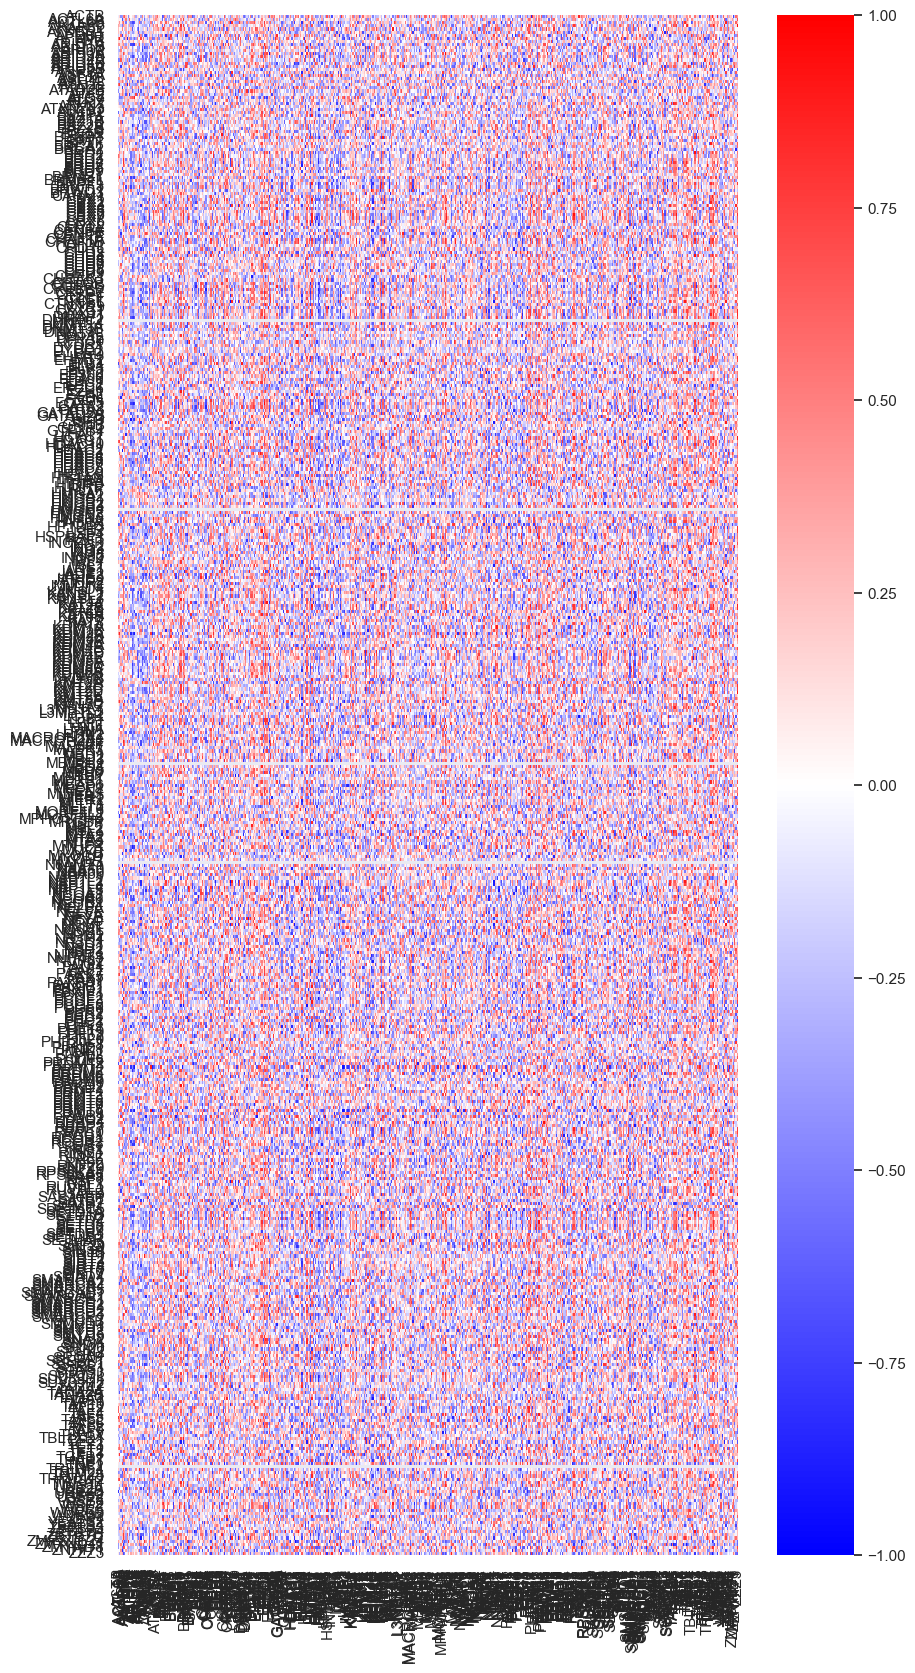

In [17]:
# All Rows
sns.set(font_scale=1)
plt.figure(figsize=(10,20))
sns.heatmap(gene_effect_matrix_df, vmin=-1,vmax=1, cmap='bwr', xticklabels=True, yticklabels=True)

Text(0.5, 1.0, 'mRNA vs. Gene Dependency Heatmap (Positive or Negative Correlates)')

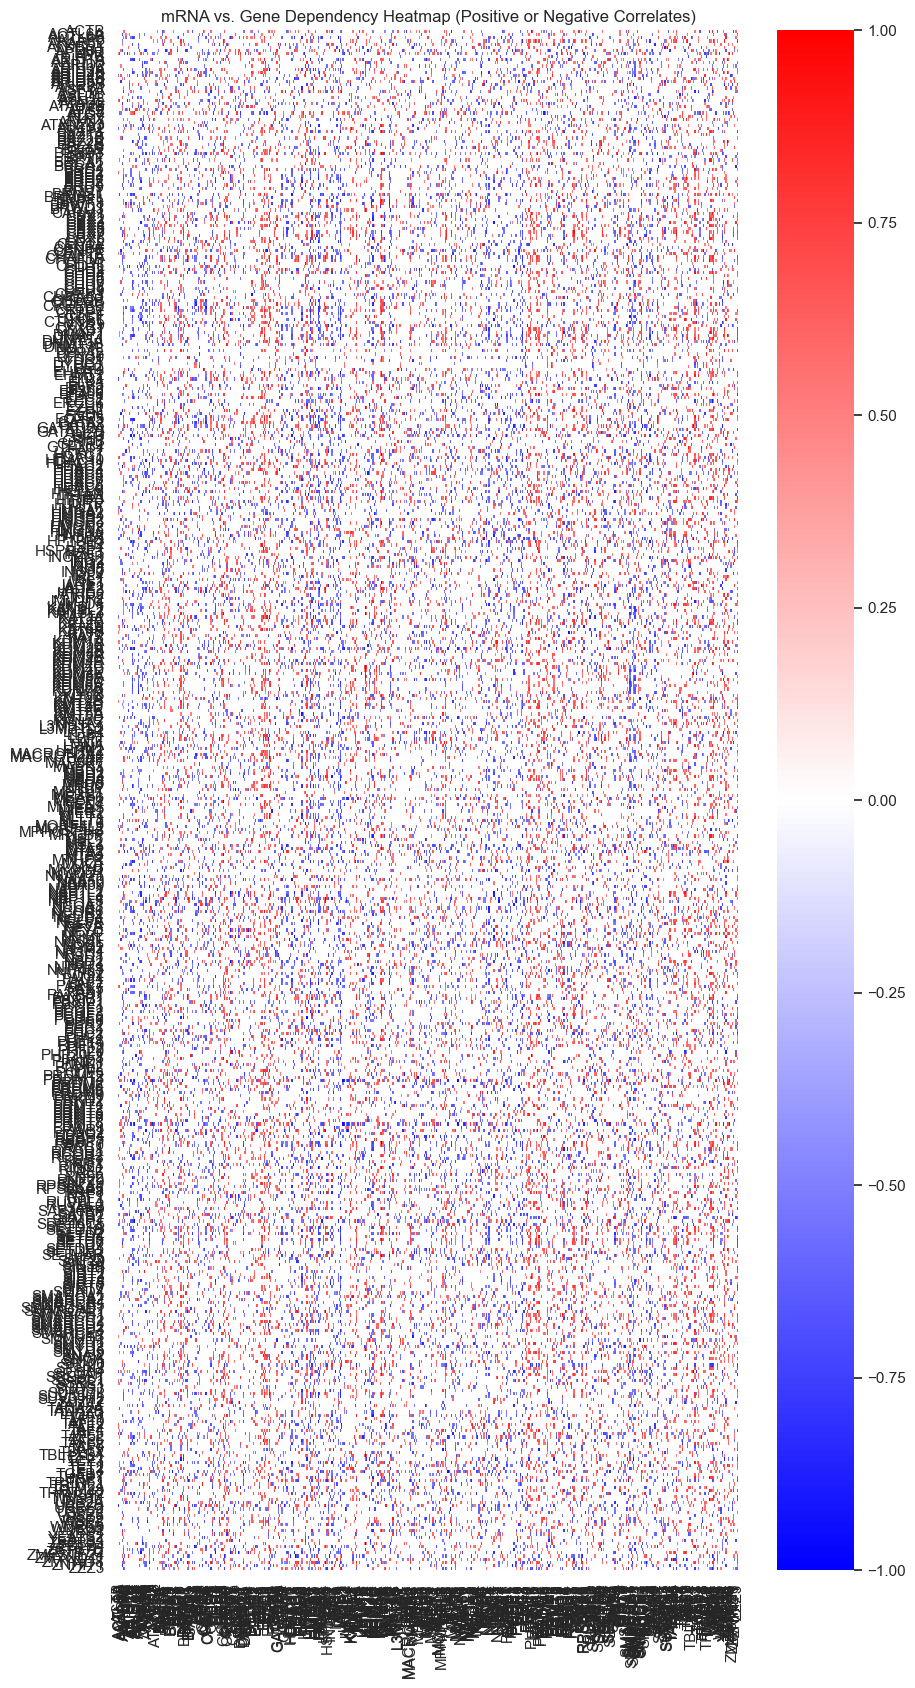

In [20]:
# Rows that were < .05
sns.set(font_scale=1)
plt.figure(figsize=(10,20))
sns.heatmap(significant_rows_df, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True)
plt.title('mRNA vs. Gene Dependency Heatmap (Positive or Negative Correlates)')


In [19]:
for gene in significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all').columns:
    with open("GeneCards Lookup.txt", "a") as file:
        file.write(gene + ':' + '\n')
        file.write('https://www.genecards.org/cgi-bin/carddisp.pl?gene=' + gene + '\n')
        file.write('\n')
    
file.close()

for gene in significant_rows_df.dropna(axis=0, how='all').dropna(axis=1, how='all').index:
    with open("GeneCards Lookup.txt", "a") as file:
        file.write(gene + ':' + '\n')
        file.write('https://www.genecards.org/cgi-bin/carddisp.pl?gene=' + gene + '\n')
        file.write('\n')

flie.close()

NameError: name 'flie' is not defined

(11,)
(49,)
(11,)
(49,)


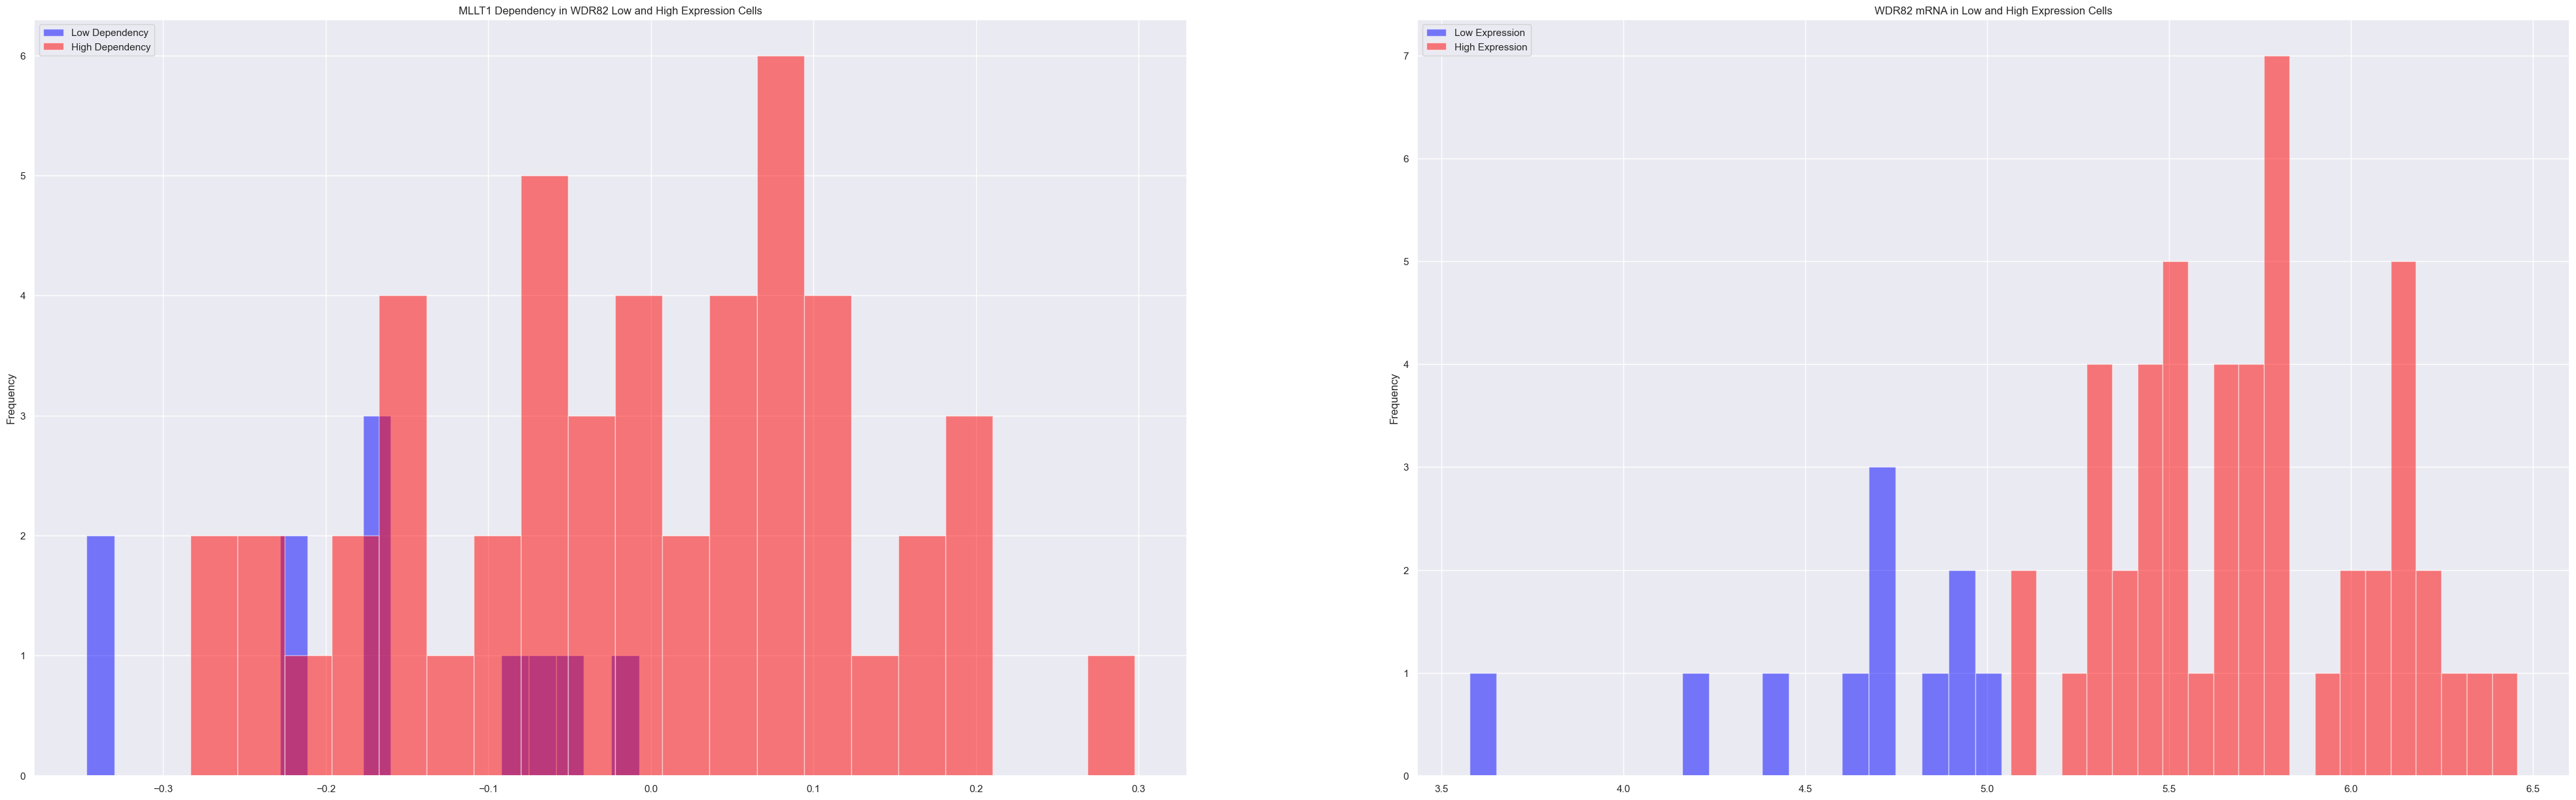

In [ ]:
# Manual Validation
gene = 'WDR82'
gene2 = 'MLLT1'
low_expression = gene_groups[gene_groups[gene] == 'low'].index
high_expression = gene_groups[gene_groups[gene] == 'high'].index


low_expression_dependency = dependency_df.loc[low_expression, gene2]
high_expression_dependency = dependency_df.loc[high_expression, gene2]


# T-Test of Gene Dependency in Low and High Expression Cells
ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')

# Add the t-statistic to the gene effect matrix
significant_rows_df[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[0]

fig,ax = plt.subplots(1,2,figsize=(50,15))

ax[0].hist(low_expression_dependency, bins=20, color='blue', alpha=0.5, label='Low Dependency')
ax[0].hist(high_expression_dependency, bins=20, color='red', alpha=0.5, label='High Dependency')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Frequency')
ax[0].set_title(gene2 + ' Dependency in ' + gene + ' Low and High Expression Cells')

# mRNA
ax[1].hist(mRNA_df.loc[low_expression, gene], bins=20, color='blue', alpha=0.5, label='Low Expression')
ax[1].hist(mRNA_df.loc[high_expression, gene], bins=20, color='red', alpha=0.5, label='High Expression')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Frequency')
ax[1].set_title(gene + ' mRNA in Low and High Expression Cells')


print(low_expression.shape)
print(high_expression.shape)
print(low_expression_dependency.shape)
print(high_expression_dependency.shape)
    